# **Understanding the Concept**

**Autoencoders** are a type of neural network used to compress and reconstruct data. They have two main parts:
1. **Encoder**: compresses the input into a smaller (lower-dimensional) version.
2. **Decoder**: tries to rebuild the original input from that smaller version.

The goal is to minimize the difference between the input and the output. But if not designed carefully, the model might just copy the input (acting like an identity function), which doesn’t teach it anything useful.



**What is a Denoising Autoencoder (DAE)?**

A DAE is an improved version of an autoencoder. Instead of giving the clean input to the model, we give it a **noisy version and train it to reconstruct the clean version**. This makes the model learn more useful patterns and reduces the risk of just copying the input.

**How it works:**
1. We add noise to the input (like random pixels or Gaussian noise).
2. The encoder gets this noisy input and compresses it.
3. The decoder tries to rebuild the original (clean) input.
4. We calculate the loss between the clean input and the reconstructed output.

**Why use DAE?**
  * Helps the model learn to fix or clean data.
  * Can be useful for image denoising, filling missing values, or working with noisy data.
  * Makes the model more robust and generalizable.

# **Data Introduction**

## ***Data Understanding: What is in this dataset?***
The Fashion MNIST dataset isn’t made up of colorful fashion photos or magazine pictures,these are grayscale images (black-and-white) of fashion items, designed to test how well a computer model can recognize and classify everyday clothing.
<br>
<br>

Each image in this dataset is a 28×28 pixel picture (very small!) of a single clothing item. Even though the images are tiny and in black-and-white, they still contain enough detail for machine learning models to learn patterns.
<br>
<br>

This dataset was created as a more challenging replacement for the classic MNIST digit dataset (which has handwritten numbers). It helps researchers and students test their image classification models on something more realistic than just digits.
<br>
<br>

So in a nutshell, this dataset contains:
* Grayscale images of clothing items: each image shows one item such as a shirt, sneaker, bag, or coat.
* Labels for each image: each image comes with a label (from 0 to 9), telling you what kind of clothing it

> ***Big thanks for generoulsy brainful people on earth for making excellent contents to sustain the existent of brainless people like me. So here's some references:***
* [Denoising AutoEncoders In Machine Learning](https://www.geeksforgeeks.org/denoising-autoencoders-in-machine-learning/)
* [AutoEncoder Denoising](https://www.kaggle.com/code/abdallahwagih/autoencoder-denoising)

In [29]:
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Cropping2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from skimage.metrics import structural_similarity as ssim

In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

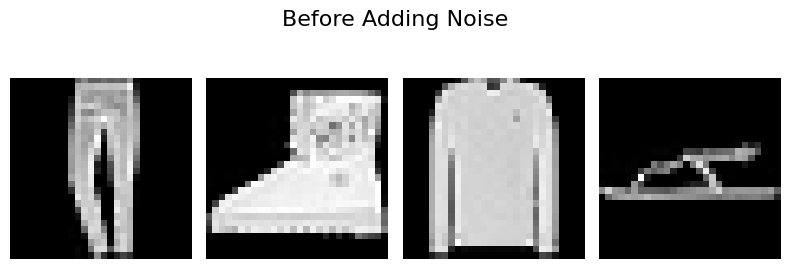

In [3]:
fig, ax = plt.subplots(ncols=4, figsize=(8, 3))
fig.suptitle('Before Adding Noise', fontsize=16)

for idx in range(4):
    batch_idx = np.random.randint(x_train.shape[0])
    ax[idx].imshow(x_train[batch_idx], cmap='gray')
    ax[idx].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

In [4]:
# Data Normalization
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Reshape data for CNN input
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# **Adding Noise**

In [5]:
# adding Gaussian noise
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

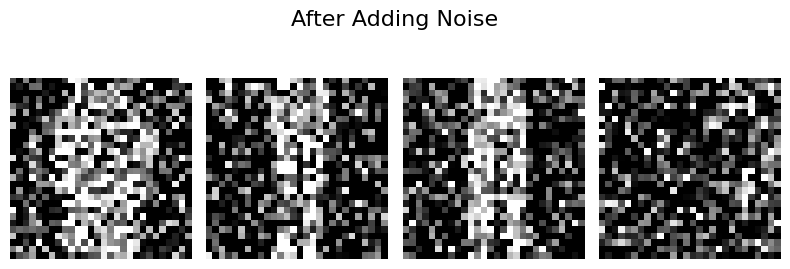

In [6]:
fig, ax = plt.subplots(ncols=4, figsize=(8, 3))
fig.suptitle('After Adding Noise', fontsize=16)

for idx in range(4):
    batch_idx = np.random.randint(x_train_noisy.shape[0])
    ax[idx].imshow(x_train_noisy[batch_idx].squeeze(), cmap='gray')
    ax[idx].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

# **Training**

In [7]:
model = Sequential()

# encoder         grayscale input
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))  # 28x28x1 → 28x28x32
model.add(MaxPooling2D((2, 2), padding='same'))  # 28x28x32 → 14x14x32
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))  # 14x14x32 → 14x14x8
model.add(MaxPooling2D((2, 2), padding='same'))  # 14x14x8 → 7x7x8
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))  # 7x7x8 → 7x7x8
model.add(MaxPooling2D((2, 2), padding='same'))  # 7x7x8 → 4x4x8

# decoder
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))  # 4x4x8 → 4x4x8
model.add(UpSampling2D((2, 2)))  # 4x4x8 → 8x8x8
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))  # 8x8x8 → 8x8x8
model.add(UpSampling2D((2, 2)))  # 8x8x8 → 16x16x8
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))  # 16x16x8 → 16x16x32
model.add(UpSampling2D((2, 2)))  # 16x16x32 → 32x32x32

# Final layer to return to 1 channel with sigmoid (for [0,1] normalized image output)
model.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))  # 32x32x32 → 32x32x1

# Crop back to 28x28 to match original input
model.add(Cropping2D(((2, 2), (2, 2))))  # 32x32x1 → 28x28x1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Loss: Binary Crossentropy**
We use binary crossentropy because our images are normalized to the range [0, 1], and the model’s output is a pixel-wise probability. This loss helps the model learn how close each pixel is to being 0 or 1, making it effective for image reconstruction tasks like denoising.
<br>
<br>
**Metrics**
1. **MAE (Mean Absolute Error):** Measures the average difference between predicted and actual pixel values. It's easy to interpret and shows overall reconstruction error.
<br>
<br>
2. **MSE (Mean Squared Error):** Emphasizes larger errors more than MAE, helping the model pay attention to significant pixel differences.
<br>
<br>
3. **Cosine Similarity:** Checks how similar the predicted image is to the actual one in terms of overall shape or structure, rather than individual pixel values. It’s useful to see if the model is capturing the right patterns.

In [8]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['mae', 'mse', 'cosine_similarity']
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 8)      │         2,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 32)     │         2,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 1)      │           289 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping2d (Cropping2D)         │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,009 (27.38 KB)

 Trainable params: 7,009 (27.38 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,            # stop if no improvement after 10 epochs
    restore_best_weights=True
)

In [10]:
history = model.fit(
              x_train_noisy,  # noisy inputs
              x_train,        # clean targets
              epochs=100,
              batch_size=256,
              shuffle=True,
              validation_data=(x_test_noisy, x_test),
              callbacks=[early_stop]
          )

Epoch 1/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - cosine_similarity: 0.4979 - loss: 0.5060 - mae: 0.2437 - mse: 0.0927 - val_cosine_similarity: 0.5001 - val_loss: 0.3414 - val_mae: 0.1080 - val_mse: 0.0318
Epoch 2/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - cosine_similarity: 0.4991 - loss: 0.3357 - mae: 0.1047 - mse: 0.0304 - val_cosine_similarity: 0.5001 - val_loss: 0.3271 - val_mae: 0.0960 - val_mse: 0.0273
Epoch 3/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - cosine_similarity: 0.4980 - loss: 0.3236 - mae: 0.0952 - mse: 0.0268 - val_cosine_similarity: 0.5001 - val_loss: 0.3225 - val_mae: 0.0924 - val_mse: 0.0258
Epoch 4/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - cosine_similarity: 0.4985 - loss: 0.3203 - mae: 0.0920 - mse: 0.0255 - val_cosine_similarity: 0.5001 - val_loss: 0.3214 - val_mae: 0.0925 - val_mse: 0.0254
Epoch 5/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - cosine_similarity: 0.4976 - loss: 0.3173 - mae: 0.0902 - mse: 0.0248 - val_cosine_similarity: 0.5

# **Evaluation**

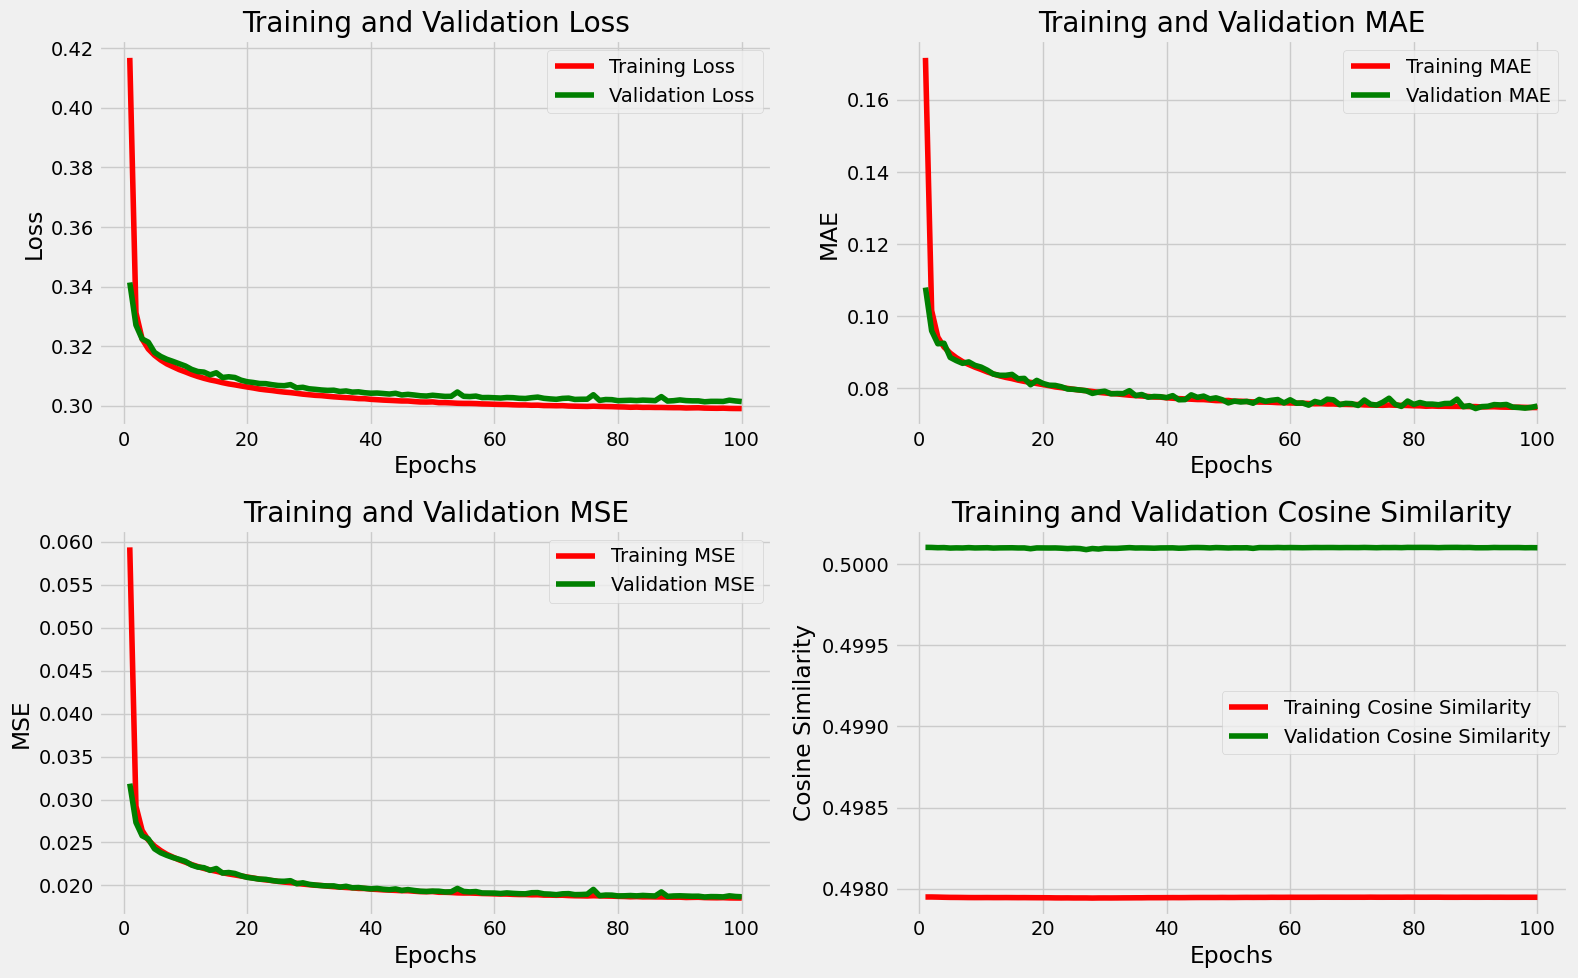

In [14]:
def plot_training_reconstruction(hist):
    tr_loss = hist.history.get('loss')
    val_loss = hist.history.get('val_loss')

    tr_mae = hist.history.get('mae')
    val_mae = hist.history.get('val_mae')

    tr_mse = hist.history.get('mse')
    val_mse = hist.history.get('val_mse')

    tr_cos = hist.history.get('cosine_similarity')
    val_cos = hist.history.get('val_cosine_similarity')

    epochs = range(1, len(tr_loss) + 1)

    plt.figure(figsize=(16, 10))
    plt.style.use('fivethirtyeight')

    # loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, tr_loss, 'r-', label='Training Loss')
    plt.plot(epochs, val_loss, 'g-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # MAE
    plt.subplot(2, 2, 2)
    plt.plot(epochs, tr_mae, 'r-', label='Training MAE')
    plt.plot(epochs, val_mae, 'g-', label='Validation MAE')
    plt.title('Training and Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()

    # MSE
    plt.subplot(2, 2, 3)
    plt.plot(epochs, tr_mse, 'r-', label='Training MSE')
    plt.plot(epochs, val_mse, 'g-', label='Validation MSE')
    plt.title('Training and Validation MSE')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend()

    # cosine similarity
    plt.subplot(2, 2, 4)
    plt.plot(epochs, tr_cos, 'r-', label='Training Cosine Similarity')
    plt.plot(epochs, val_cos, 'g-', label='Validation Cosine Similarity')
    plt.title('Training and Validation Cosine Similarity')
    plt.xlabel('Epochs')
    plt.ylabel('Cosine Similarity')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_reconstruction(history)

**Top-Left: Training and Validation Loss**
  * Trend: Both training and validation loss decrease smoothly.
  * The model is learning effectively without overfitting.
  * Convergence happens around epoch 40–50.
<br>
<br>

**Top-Right: Training and Validation MAE (Mean Absolute Error)**
  * Trend: MAE decreases over time for both training and validation.
  * The average difference between predicted and true pixel values is reducing, meaning the reconstructions are getting closer to the originals.
<br>
<br>

**Bottom-Left: Training and Validation MSE (Mean Squared Error)**
  * Trend: Similar to MAE, MSE also decreases and stabilizes.
  * Indicates the pixel-level reconstruction quality is improving steadily. MSE penalizes larger errors more than MAE, and it’s also low here, which is good.
<br>
<br>

**Bottom-Right: Cosine Similarity**
  * Trend: Flat lines around 0.498 for both training and validation.
  * Cosine similarity isn’t improving and stays near 0.5, which suggests it may not be meaningful for this task or the data has near-zero vectors.

  WE SHOULD CONSIDER NOT TO USE COSINE SIMILARITY FOR THE NEXT PROJECT BECAUSE IT HAS NO MEANINGFUL BENEFIT

In [35]:
mae_list = []
mse_list = []
cosine_list = []

for i in range(len(x_test)):
    true = x_test[i].flatten()
    pred = no_noise_img[i].flatten()

    mae_list.append(mean_absolute_error(true, pred))
    mse_list.append(mean_squared_error(true, pred))
    cosine_list.append(1 - cosine(true, pred))

# convert to numpy arrays
mae_array = np.array(mae_list)
mse_array = np.array(mse_list)
cosine_array = np.array(cosine_list)

print("~~~~~~~~~ Evaluation Metrics Summary ~~~~~~~~~ ")
print(f"MAE  - Mean: {mae_array.mean():.6f} | Min: {mae_array.min():.6f} | Max: {mae_array.max():.6f}")
print(f"MSE  - Mean: {mse_array.mean():.6f} | Min: {mse_array.min():.6f} | Max: {mse_array.max():.6f}")
print(f"COS  - Mean: {cosine_array.mean():.6f} | Min: {cosine_array.min():.6f} | Max: {cosine_array.max():.6f}")

~~~~~~~~~ Evaluation Metrics Summary ~~~~~~~~~ 
MAE  - Mean: 0.075383 | Min: 0.024547 | Max: 0.237996
MSE  - Mean: 0.018653 | Min: 0.003185 | Max: 0.095180
COS  - Mean: 0.927914 | Min: 0.462524 | Max: 0.994457


**Mean Absolute Error (MAE)**
  * **Mean: 0.075**
  * This means that on average, each pixel in the **denoised image differs** from the original by about 7.5% of the maximum intensity range.
  * Lower is better. The values are relatively small, which indicates the model is doing a decent job.
<br>
<br>

**Mean Squared Error (MSE)**
  * **Mean: 0.018**
  * Like MAE, but it penalizes larger errors more strongly. The average squared error per pixel is around 1.8%, which is also low.
<br>
<br>

**Cosine Similarity**
  * **Mean: 0.928**
  * Ranges from 0 to 1, where 1 means the images are very similar in direction (structure/pattern).
  * A score of 0.93 means **the denoised images are structurally very close to the original ones.**
  * he minimum (0.46) shows that a **few images were poorly denoised**, but the majority are good.

AGAIN WE SHOULD REMOVE COSINE SIMILARTIY BECAUSE IT SHOW NO RELEVANCY

In [30]:
ssim_scores = []

for denoised, original in zip(no_noise_img, x_test):
    # remove channel dimension for SSIM (for grayscale)
    denoised_img = denoised.reshape(28, 28)
    original_img = original.reshape(28, 28)

    score = ssim(
        denoised_img,
        original_img,
        data_range=1.0  # since images are normalized to [0, 1]
    )
    ssim_scores.append(score)

ssim_scores = np.array(ssim_scores)
print("Mean SSIM:", np.mean(ssim_scores))
print("Max SSIM:", np.max(ssim_scores))
print("Min SSIM:", np.min(ssim_scores))
print("Index with highest SSIM:", np.argmax(ssim_scores))
print("Index with lowest SSIM:", np.argmin(ssim_scores))

Mean SSIM: 0.6142962681343401
Max SSIM: 0.9597557507270624
Min SSIM: 0.08178884253540357
Index with highest SSIM: 2925
Index with lowest SSIM: 8321


**Mean SSIM: 0.614**

On average, your denoised images are about 61% structurally similar to the original images.
<br>
<br>

**Max SSIM: 0.96**
The best-case output image is 96% similar to its original version. This shows your model can perform very well on certain samples.
<br>
<br>

**Min SSIM: 0.08**
The worst-case output only had 8% structural similarity, meaning it was very poorly reconstructed. This indicates that the model struggles on certain types of images (could be highly noisy or complex ones)

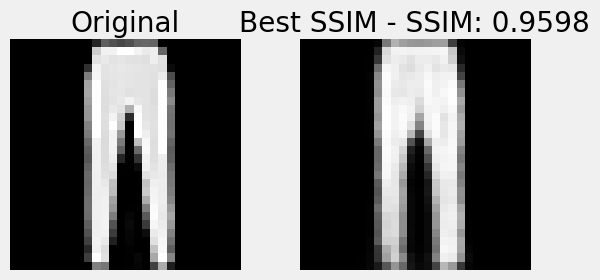

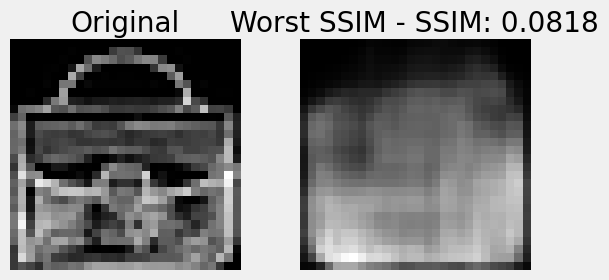

In [33]:
for idx, label in zip([np.argmax(ssim_scores), np.argmin(ssim_scores)], ["Best SSIM", "Worst SSIM"]):
    plt.figure(figsize=(6, 3))

    # Original
    plt.subplot(1, 2, 1)
    plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis("off")

    # Denoised
    plt.subplot(1, 2, 2)
    plt.imshow(no_noise_img[idx].reshape(28, 28), cmap='gray')
    plt.title(f"{label} - SSIM: {ssim_scores[idx]:.4f}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# **Prediction**

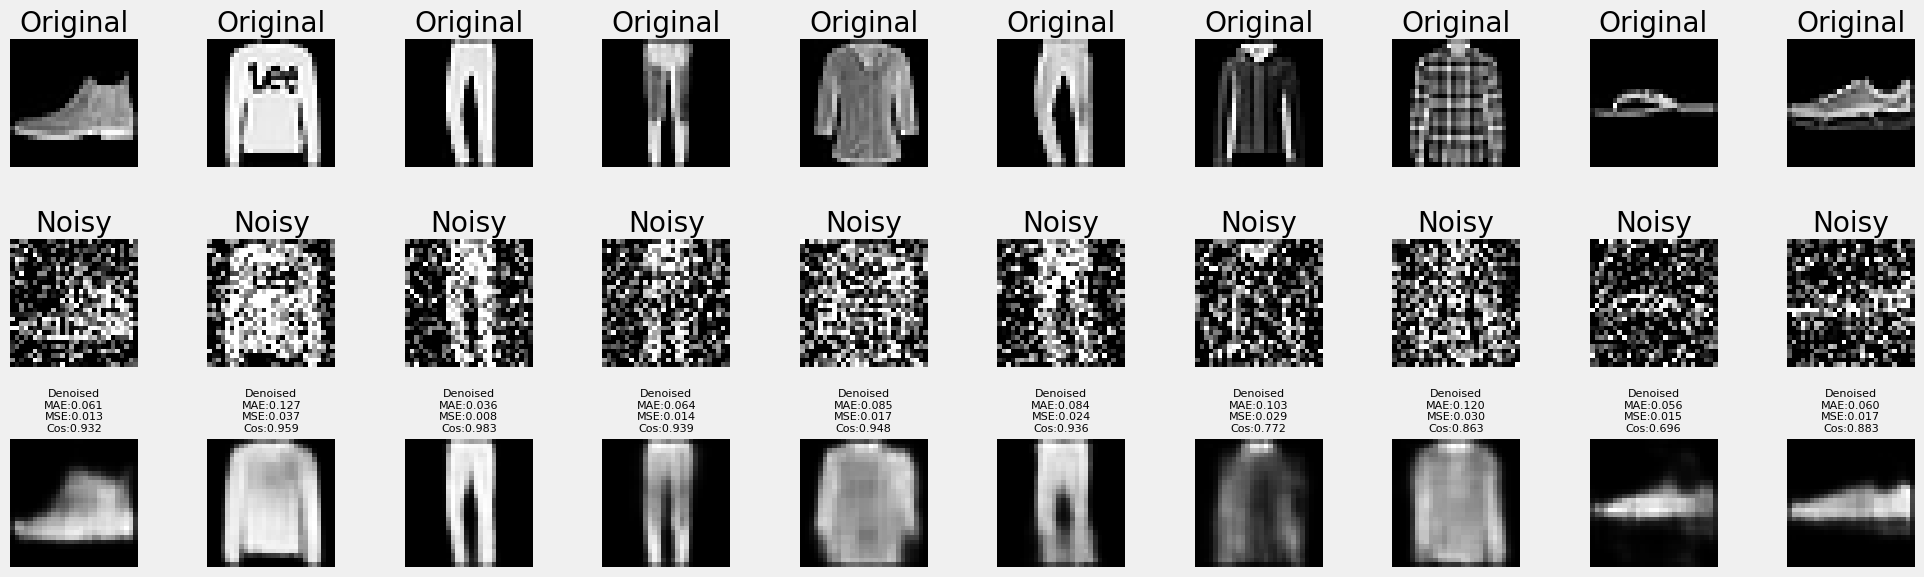

In [22]:
plt.figure(figsize=(20, 6))
for i in range(10):
    # Flatten for metric calculation
    true_img = x_test[i].flatten()
    denoised_img = no_noise_img[i].flatten()

    # Compute metrics
    mae = mean_absolute_error(true_img, denoised_img)
    mse = mean_squared_error(true_img, denoised_img)
    cos = 1 - cosine(true_img, denoised_img)  # cosine similarity

    # Original image
    ax = plt.subplot(3, 10, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # Noisy image
    ax = plt.subplot(3, 10, i + 11)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap="gray")
    plt.title("Noisy")
    plt.axis("off")

    # Denoised image
    ax = plt.subplot(3, 10, i + 21)
    plt.imshow(no_noise_img[i].reshape(28, 28), cmap="gray")
    ax.set_title("Denoised\nMAE:{:.3f}\nMSE:{:.3f}\nCos:{:.3f}".format(mae, mse, cos), fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()

# **Conclusion**

The denoising model shows promising performance in reconstructing clean images from noisy inputs. This is reflected by the steady decline in training and validation loss, MAE (Mean Absolute Error), and MSE (Mean Squared Error) over 100 epochs. **These metrics suggest that the model is learning effectively and generalizing well to unseen validation data, without overfitting.** In particular, the MAE and MSE values became quite small, indicating that, on average, the predicted pixel values are close to the actual values in the original clean images.
<br>
<br>

Additionally, the Structural Similarity Index (SSIM), which measures how similar two images are in terms of structure and perceived quality gives us deeper insight into the model's visual performance. The average SSIM score was around 0.61, with the best reaching up to 0.96. **This means the model is often capable of generating results that look very similar to the ground truth.** However, there were also cases with low SSIM (0.08), indicating that some images were not reconstructed well. **These failures usually occurred on more complex or detailed objects (like handbags), suggesting the model may struggle with intricate patterns or textures.**
<br>
<br>

On the other hand, cosine similarity did not vary much and stayed flat throughout training. This suggests that cosine similarity might not be the most informative metric for this task, likely because it captures directional similarity of flattened vectors rather than image structure or pixel-wise accuracy. So, we may rely more on MAE, MSE, and SSIM for evaluating denoising performance.